In [14]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [15]:
def bruteForce(img1path, img2path):
  img1 = cv.imread(img1path, cv.IMREAD_GRAYSCALE)
  img2 = cv.imread(img2path, cv.IMREAD_GRAYSCALE)

  orb = cv.ORB_create()
  keypoints1, descriptor1 = orb.detectAndCompute(img1, None)
  keypoints2, descriptor2 = orb.detectAndCompute(img2, None)
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
  matches = bf.match(descriptor1, descriptor2)
  matches = sorted(matches, key=lambda x:x.distance)
  nMatches = 10
  imgMatch = cv.drawMatches(img1, keypoints1, img2, keypoints2,\
                            matches[:nMatches], None,\
                            flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.figure(figsize=(10, 10))
  plt.imshow(imgMatch)
  plt.show()


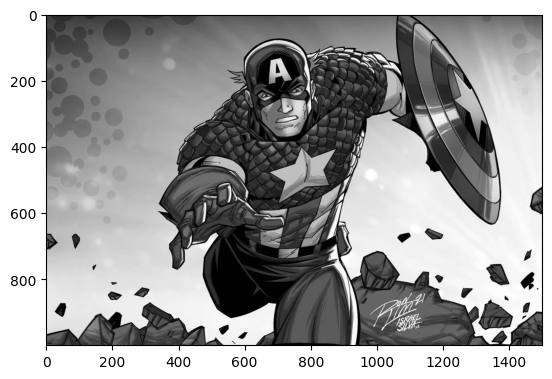

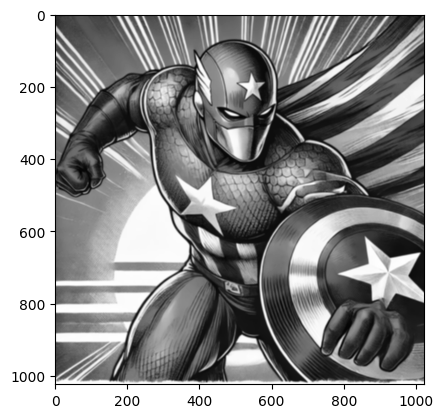

Similarity using ORB is:  0.3229166666666667
Similarity using SSIM is:  0.30793513723216226


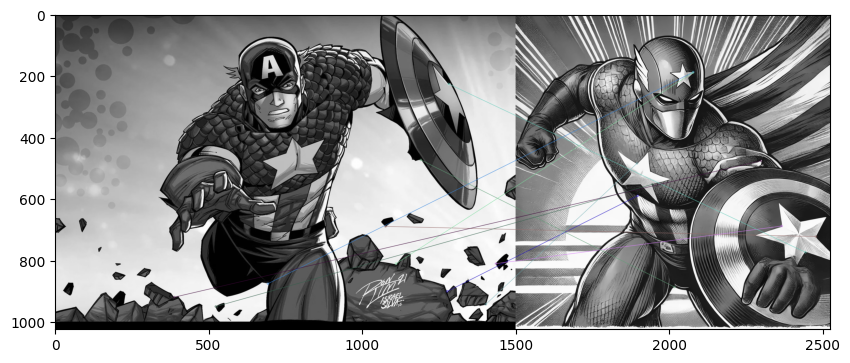

In [16]:
# https://youtu.be/16s3Pi1InPU
"""
Comparing images using ORB/SIFT feature detectors
and structural similarity index.

@author: Sreenivas Bhattiprolu
"""


from skimage.metrics import structural_similarity
import cv2

#Works well with images of different dimensions
def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  #perform matches.
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance <50]
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)


#Needs images to be same dimensions
def structural_sim(img1, img2):

  sim, diff = structural_similarity(img1, img2, full=True)
  return sim

img00 = cv2.imread('/content/cap2_r.jpg', 0)
img01 = cv2.imread('/content/cap2_f.jpg', 0)

kernel = np.ones((5,5),np.float32)/25
img2 = cv.filter2D(img01,-1,kernel)
plt.imshow(img00, cmap=plt.cm.gray)
plt.show()
plt.imshow(img2, cmap=plt.cm.gray)
plt.show()

orb_similarity = orb_sim(img00, img2)  #1.0 means identical. Lower = not similar

print("Similarity using ORB is: ", orb_similarity)
#Resize for SSIM
from skimage.transform import resize
img4 = resize(img2, (img00.shape[0], img00.shape[1]), anti_aliasing=True, preserve_range=True)

ssim = structural_sim(img00, img4) #1.0 means identical. Lower = not similar
print("Similarity using SSIM is: ", ssim)
bruteForce('/content/cap2_r.jpg', '/content/cap2_f.jpg')

In [17]:
# https://youtu.be/zN9ZINn7g24
"""
@author: DigitalSreeni

This file provides the VGG16 method to be applied on images to extract features.
These features can then be used for content based image retrieval.
Please note that Imagenet pre-trained weights will be loaded to VGG16
and the output from the final layer has a shape of 512 - our feature vector length.


"""

import numpy as np
from numpy import linalg as LA

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

#Understand the VGG16 model.
# model = VGG16(weights = 'imagenet',
#               input_shape = ((224, 224, 3)),
#               pooling = 'max',
#               include_top = False)
# model.summary()
#See how the final output gives us a vector oof size 512


class VGGNet:
    def __init__(self):
        # weights: 'imagenet'
        # pooling: 'max' or 'avg'
        # input_shape: (width, height, 3), width and height should >= 48
        self.input_shape = (224, 224, 3)
        self.weight = 'imagenet'
        self.pooling = 'max'
        self.model = VGG16(weights = self.weight, input_shape = (self.input_shape[0], self.input_shape[1], self.input_shape[2]), pooling = self.pooling, include_top = False)
        self.model.predict(np.zeros((1, 224, 224 , 3)))


    '''
    Use vgg16 model to extract features
    Output normalized feature vector
    '''
    def extract_feat(self, img_path):
        img = image.load_img(img_path, target_size=(self.input_shape[0], self.input_shape[1]))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feat = self.model.predict(img)
        norm_feat = feat[0]/LA.norm(feat[0])
        return norm_feat


In [18]:
from scipy import spatial
model = VGGNet()
original = model.extract_feat('/content/cap2_r.jpg')
try4 = model.extract_feat('/content/cap2_f.jpg')
# cat = model.extract_feat('/content/cat.png')
score_original = 1-spatial.distance.cosine(original, original)
score_try4 = 1-spatial.distance.cosine(original, try4)
# score_cat = 1-spatial.distance.cosine(original, cat)

1/1 [==============================] - 0s 477ms/step


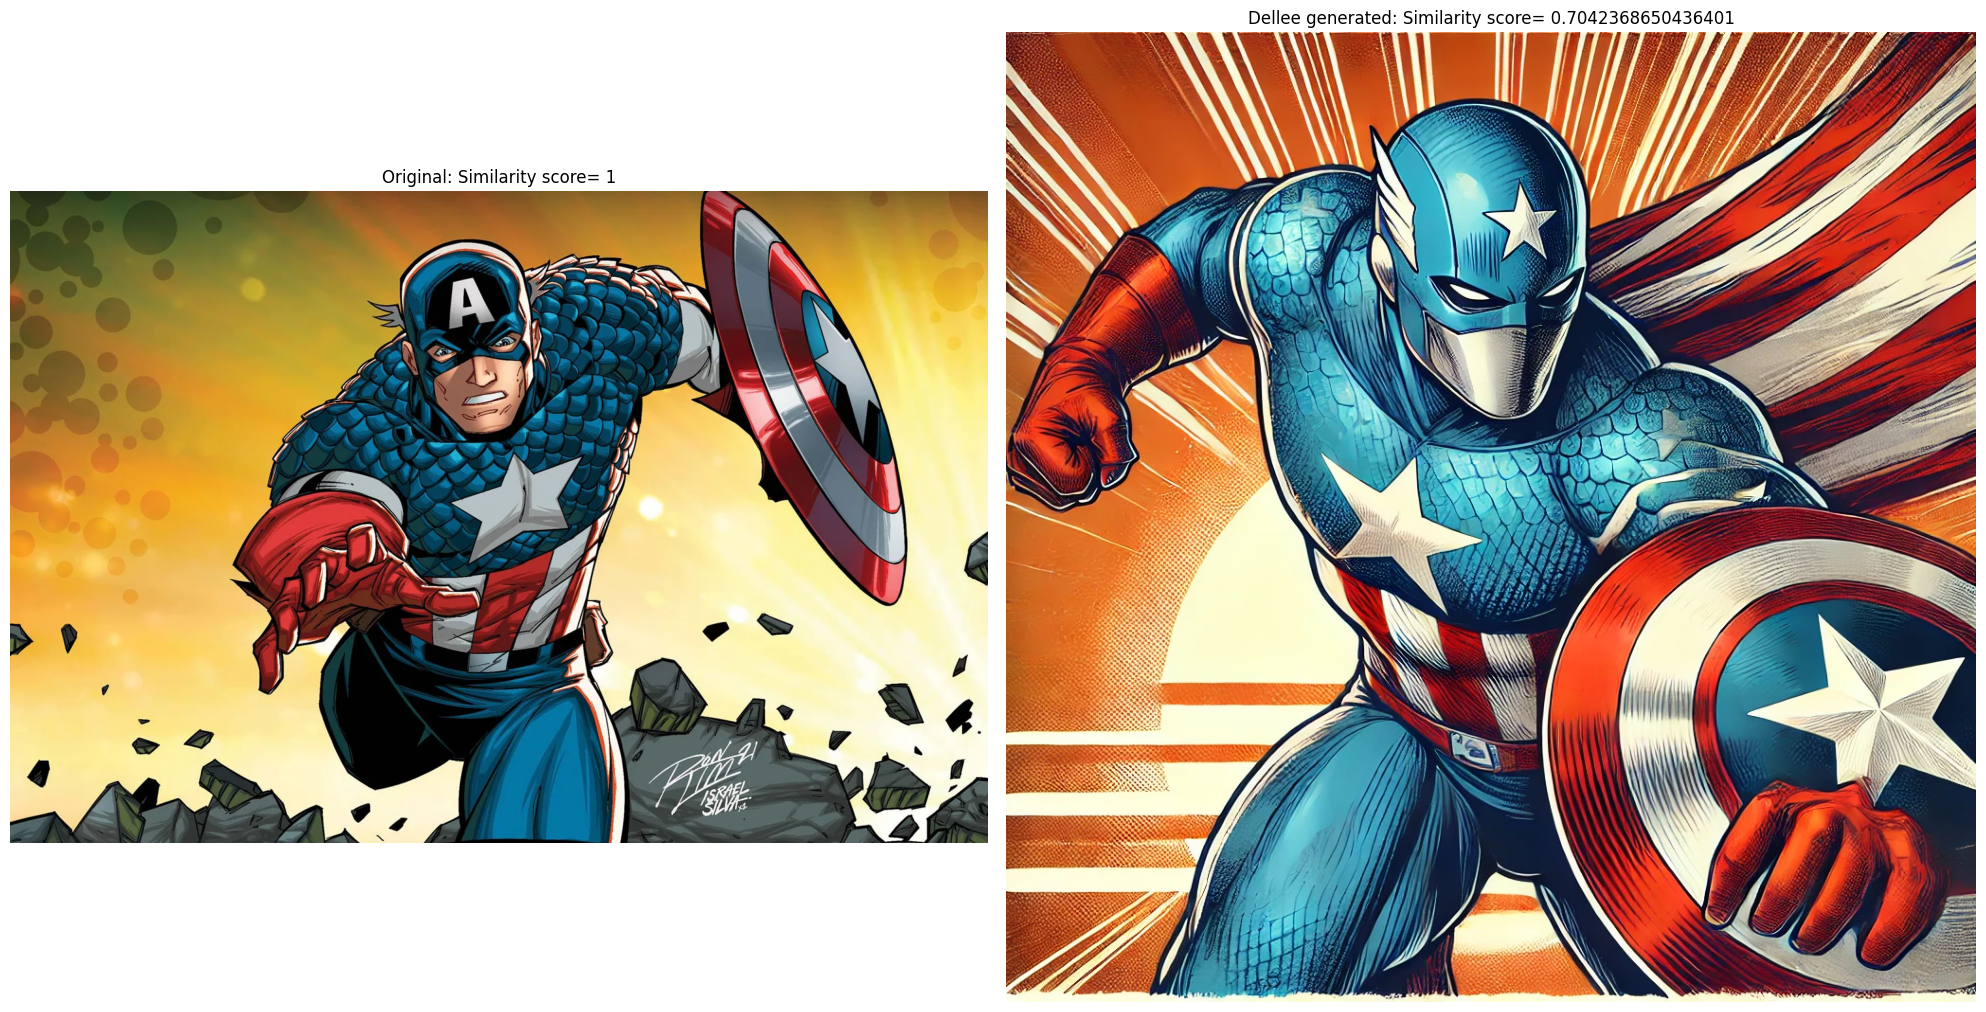

In [19]:
original = cv2.imread('/content/cap2_r.jpg')
try4 = cv2.imread('/content/cap2_f.jpg')
# cat = cv2.imread('/content/cat.png')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Display each image
axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[0].axis('off')  # Hide axes
axs[0].set_title(f'Original: Similarity score= {score_original}')

axs[1].imshow(cv2.cvtColor(try4, cv2.COLOR_BGR2RGB))
axs[1].axis('off')  # Hide axes
axs[1].set_title(f'Dellee generated: Similarity score= {score_try4}')

# axs[2].imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))
# axs[2].axis('off')  # Hide axes
# axs[2].set_title(f'A cat: Similarity score= {score_cat}')

# Display the images
plt.tight_layout()
plt.show()

In [21]:
!unzip -oq superhero_dataset.zip

In [31]:
def get_similarity_score(path1, path2):
  img_feature1 = model.extract_feat(path1)
  img_feature2 = model.extract_feat(path2)
  return 1-spatial.distance.cosine(img_feature1, img_feature2)

In [54]:
import os
import pandas as pd
from IPython.display import display, clear_output, HTML
from PIL import Image
from io import BytesIO
import base64

# Define the paths to the two folders
real_folder = '/content/real'
generated_folder = '/content/generated'

# Function to find matching twin images based on similar names
def find_twin_images(folder1, folder2):
    images1 = os.listdir(folder1)
    images2 = os.listdir(folder2)

    # Create a list to store the matched images
    matched_images = []

    for img1 in images1:
        img1_base = os.path.splitext(img1)[0][:-2]  # Get the base name without extension
        for img2 in images2:
            img2_base = os.path.splitext(img2)[0][:-2]  # Get the base name without extension
            if img1_base in img2_base or img2_base in img1_base:
                sim = get_similarity_score(os.path.join(folder1, img1), os.path.join(folder2, img2))
                matched_images.append((os.path.join(folder1, img1), os.path.join(folder2, img2), sim))
                break  # Stop searching once a match is found

    return matched_images

# Find the twin images
twin_images = find_twin_images(real_folder, generated_folder)

# Create a DataFrame to store the matched images
df = pd.DataFrame(twin_images, columns=['Image1', 'Image2', 'Similarity Score'])

clear_output(wait=True)
display(df)

Image1                               Image2  \
0       /content/real/storm2_r.jpg      /content/generated/storm2_f.jpg   
1   /content/real/wolverine2_r.jpg  /content/generated/wolverine2_f.jpg   
2     /content/real/magneto2_r.jpg    /content/generated/magneto2_f.jpg   
3     /content/real/scarlet2_r.jpg    /content/generated/scarlet2_f.jpg   
4   /content/real/wolverine1_r.jpg  /content/generated/wolverine1_f.jpg   
5         /content/real/oct2_r.jpg        /content/generated/oct2_f.jpg   
6     /content/real/ironman1_r.jpg    /content/generated/ironman1_f.jpg   
7     /content/real/magneto1_r.jpg    /content/generated/magneto1_f.jpg   
8         /content/real/cap2_r.jpg        /content/generated/cap2_f.jpg   
9         /content/real/cap1_r.jpg        /content/generated/cap1_f.jpg   
10      /content/real/storm1_r.jpg      /content/generated/storm1_f.jpg   
11  /content/real/spiderman2_r.jpg  /content/generated/spiderman2_f.jpg   
12  /content/real/spiderman1_r.jpg  /content/generated/spiderman1_f.jpg   
13        /content/real/oct1_r.jpg        /content/generated/oct1_f.jpg   
14    /content/real/cyclops2_r.jpg    /content/generated/cyclops2_f.jpg   
15    /content/real/scarlet1_r.jpg    /content/generated/scarlet1_f.jpg   
16    /content/real/ironman2_r.jpg    /content/generated/ironman2_f.jpg   
17    /content/real/cyclops1_r.jpg    /content/generated/cyclops1_f.jpg   

    Similarity Score  
0           0.528106  
1           0.678756  
2           0.641645  
3           0.685469  
4           0.672570  
5           0.648607  
6           0.715057  
7           0.718898  
8           0.704237  
9           0.685260  
10          0.659262  
11          0.804150  
12          0.727515  
13          0.680776  
14          0.681905  
15          0.638173  
16          0.688033  
17          0.685193